## Importing

In [1]:
! pip install zfpy evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 729.2/729.2 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.3 MB/s eta 0:00:00


In [2]:
import os
import copy
import time
import zfpy
import torch
import pickle
import warnings
import evaluate
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from datasets import load_dataset, load_metric
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments, DataCollatorWithPadding

2024-06-04 23:09:59.139727: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-04 23:09:59.139846: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-04 23:09:59.278084: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Preparing

In [3]:
warnings.filterwarnings("ignore", category=FutureWarning)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
org_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased')
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

org_model.to(device)
print('device:', device)

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

device: cuda


In [4]:
def save_pkl(file: str, state_dict: dict) -> float:
    with open(file, 'wb') as f:
        pickle.dump(state_dict, f)
    return os.path.getsize(file)
        
def load_pkl(file: str) -> dict:
    with open(file, 'rb') as f:
        return pickle.load(f)

## Dataset

In [5]:
# Load dataset
dataset = load_dataset('glue', 'sst2')
metric = evaluate.load('accuracy', trust_remote_code=True)

def preprocess_function(examples):
    return tokenizer(examples['sentence'], truncation=True, padding=True)

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset = encoded_dataset.rename_column('label', 'labels')
encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

# Split the dataset
train_dataset = encoded_dataset['train']
eval_dataset = encoded_dataset['validation']

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

Generating train split:   0%|          | 0/67349 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/872 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1821 [00:00<?, ? examples/s]

Map:   0%|          | 0/67349 [00:00<?, ? examples/s]

Map:   0%|          | 0/872 [00:00<?, ? examples/s]

Map:   0%|          | 0/1821 [00:00<?, ? examples/s]

## Original Model Training

In [6]:
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='epoch',
    save_strategy='no',
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    report_to=[]
)

trainer = Trainer(
    model=org_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=data_collator,
    compute_metrics=lambda p: {'accuracy': metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)},
)

In [7]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.181900,0.265409,{'accuracy': 0.9048165137614679}
2,0.133700,0.324886,{'accuracy': 0.9105504587155964}
3,0.078000,0.399252,{'accuracy': 0.9048165137614679}


TrainOutput(global_step=12630, training_loss=0.14815418155818164, metrics={'train_runtime': 852.2064, 'train_samples_per_second': 237.087, 'train_steps_per_second': 14.82, 'total_flos': 3375846534095508.0, 'train_loss': 0.14815418155818164, 'epoch': 3.0})

In [8]:
org_size = save_pkl('org_model.pkl', org_model.state_dict())
print('org_size:', org_size)

org_eval_results = org_eval_results = trainer.evaluate()
print('org_eval_results:', org_eval_results)

org_data = {
    'tolerance': 0,
    'accuracy': org_eval_results['eval_accuracy']['accuracy'],
    'compression_ratio': 1,
    'model_size': org_size / 1024**2  # Size in MB
}

org_size: 267861790


org_eval_results: {'eval_loss': 0.39925244450569153, 'eval_accuracy': {'accuracy': 0.9048165137614679}, 'eval_runtime': 0.8442, 'eval_samples_per_second': 1032.941, 'eval_steps_per_second': 16.584, 'epoch': 3.0}


## Quantization

In [9]:
torch.set_printoptions(precision=32)

In [10]:
for name, param in org_model.named_parameters():
    copy_param = copy.deepcopy(param)
    print('Before Quantization')
    print('Name:', name)
    print('Value:', copy_param[0][0])
    print()
    
    qt16 = copy_param.to(torch.bfloat16).to(torch.float32)
    qt16_cpu = qt16.cpu().detach().numpy()
    qt16_comp = zfpy.compress_numpy(qt16_cpu[0], tolerance=1/2**4)
    qt16_dcomp = zfpy.decompress_numpy(qt16_comp)
    print('After Quantization (torch.bfloat16)')
    print('Name:', name)
    print('Value:', qt16[0][0])
    # print('ZFP Compress:', qt16_comp)
    print('ZFP Decompress:', torch.tensor(qt16_dcomp[0], dtype=torch.float32))
    print()

    qt8 = copy_param.to(torch.float8_e5m2).to(torch.float32)
    qt8_cpu = qt8.cpu().detach().numpy()
    qt8_comp = zfpy.compress_numpy(qt8_cpu[0], tolerance=1/2**4)
    qt8_dcomp = zfpy.decompress_numpy(qt8_comp)
    print('After Quantization (torch.float8_e5m2)')
    print('Name:', name)
    print('Value:', qt8[0][0])
    # print('ZFP Compress:', qt8_comp)
    print('ZFP Decompress:', torch.tensor(qt8_dcomp[0], dtype=torch.float32))
    break

Before Quantization
Name: distilbert.embeddings.word_embeddings.weight
Value: tensor(-0.01662347465753555297851562500000, device='cuda:0',
       grad_fn=<SelectBackward0>)

After Quantization (torch.bfloat16)
Name: distilbert.embeddings.word_embeddings.weight
Value: tensor(-0.01660156250000000000000000000000, device='cuda:0',
       grad_fn=<SelectBackward0>)
ZFP Decompress: tensor(-0.00781250000000000000000000000000)

After Quantization (torch.float8_e5m2)
Name: distilbert.embeddings.word_embeddings.weight
Value: tensor(-0.01562500000000000000000000000000, device='cuda:0',
       grad_fn=<SelectBackward0>)
ZFP Decompress: tensor(-0.01171875000000000000000000000000)


# ZFP

In [11]:
def apply_zfp(model, tolerance, quantization):
    params = dict()
    for name, param in model.named_parameters():
        if param.requires_grad:
            copy_param = copy.deepcopy(param)
            copy_param = copy_param.to(quantization).to(torch.float32)
            param_cpu = copy_param.cpu().detach().numpy()
            params[name] = zfpy.compress_numpy(param_cpu, tolerance=tolerance)
    return params

def load_and_decompress(file: str, model) -> None:
    params = load_pkl(file)
    for name, param in model.named_parameters():
        if name in params:
            decompressed = zfpy.decompress_numpy(params[name])
            param.data = torch.tensor(decompressed).to(device)
    os.remove(file)

## Evaluateing

In [12]:
def get_plot_data(tolerance_values):
    results = defaultdict(list)

    quantization = [
        ('Original (torch.float32)', torch.float32),
        ('Quantized (torch.bfloat16)', torch.bfloat16),
        ('Quantized (torch.float8_e5m2)', torch.float8_e5m2),
    ]
    for tolerance in tolerance_values:
        for name, quantize in quantization:
            print(name, quantize, tolerance)
            zfp_model = copy.deepcopy(org_model)
            pkl_path = f'zfp_model_{name}_{tolerance}.pkl'
            compressed_params = apply_zfp(zfp_model, tolerance=tolerance, quantization=quantize)

            zfp_size = save_pkl(pkl_path, compressed_params)
            load_and_decompress(pkl_path, zfp_model)

            # Evaluate the model that applied ZFP
            trainer_zfp = Trainer(
                model=zfp_model,
                args=training_args,
                train_dataset=train_dataset,
                eval_dataset=eval_dataset,
                data_collator=data_collator,
                compute_metrics=lambda p: {'accuracy': metric.compute(predictions=np.argmax(p.predictions, axis=1), references=p.label_ids)},
            )

            zfp_eval_results = trainer_zfp.evaluate()

            results[name].append({
                'tolerance': tolerance,
                'accuracy': zfp_eval_results['eval_accuracy']['accuracy'],
                'compression_ratio': org_size / zfp_size,
                'model_size': zfp_size / 1024**2  # Size in MB
            })
    return results

In [13]:
tolerance_values_log = [1/2**i for i in range(-2, 27)]
print(tolerance_values_log)
log_results = get_plot_data(tolerance_values_log)

[4.0, 2.0, 1.0, 0.5, 0.25, 0.125, 0.0625, 0.03125, 0.015625, 0.0078125, 0.00390625, 0.001953125, 0.0009765625, 0.00048828125, 0.000244140625, 0.0001220703125, 6.103515625e-05, 3.0517578125e-05, 1.52587890625e-05, 7.62939453125e-06, 3.814697265625e-06, 1.9073486328125e-06, 9.5367431640625e-07, 4.76837158203125e-07, 2.384185791015625e-07, 1.1920928955078125e-07, 5.960464477539063e-08, 2.9802322387695312e-08, 1.4901161193847656e-08]
Original (torch.float32) torch.float32 4.0


Quantized (torch.bfloat16) torch.bfloat16 4.0


Quantized (torch.float8_e5m2) torch.float8_e5m2 4.0


Original (torch.float32) torch.float32 2.0


Quantized (torch.bfloat16) torch.bfloat16 2.0


Quantized (torch.float8_e5m2) torch.float8_e5m2 2.0


Original (torch.float32) torch.float32 1.0


Quantized (torch.bfloat16) torch.bfloat16 1.0


Quantized (torch.float8_e5m2) torch.float8_e5m2 1.0


Original (torch.float32) torch.float32 0.5


Quantized (torch.bfloat16) torch.bfloat16 0.5


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.5


Original (torch.float32) torch.float32 0.25


Quantized (torch.bfloat16) torch.bfloat16 0.25


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.25


Original (torch.float32) torch.float32 0.125


Quantized (torch.bfloat16) torch.bfloat16 0.125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.125


Original (torch.float32) torch.float32 0.0625


Quantized (torch.bfloat16) torch.bfloat16 0.0625


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.0625


Original (torch.float32) torch.float32 0.03125


Quantized (torch.bfloat16) torch.bfloat16 0.03125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.03125


Original (torch.float32) torch.float32 0.015625


Quantized (torch.bfloat16) torch.bfloat16 0.015625


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.015625


Original (torch.float32) torch.float32 0.0078125


Quantized (torch.bfloat16) torch.bfloat16 0.0078125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.0078125


Original (torch.float32) torch.float32 0.00390625


Quantized (torch.bfloat16) torch.bfloat16 0.00390625


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.00390625


Original (torch.float32) torch.float32 0.001953125


Quantized (torch.bfloat16) torch.bfloat16 0.001953125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.001953125


Original (torch.float32) torch.float32 0.0009765625


Quantized (torch.bfloat16) torch.bfloat16 0.0009765625


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.0009765625


Original (torch.float32) torch.float32 0.00048828125


Quantized (torch.bfloat16) torch.bfloat16 0.00048828125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.00048828125


Original (torch.float32) torch.float32 0.000244140625


Quantized (torch.bfloat16) torch.bfloat16 0.000244140625


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.000244140625


Original (torch.float32) torch.float32 0.0001220703125


Quantized (torch.bfloat16) torch.bfloat16 0.0001220703125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.0001220703125


Original (torch.float32) torch.float32 6.103515625e-05


Quantized (torch.bfloat16) torch.bfloat16 6.103515625e-05


Quantized (torch.float8_e5m2) torch.float8_e5m2 6.103515625e-05


Original (torch.float32) torch.float32 3.0517578125e-05


Quantized (torch.bfloat16) torch.bfloat16 3.0517578125e-05


Quantized (torch.float8_e5m2) torch.float8_e5m2 3.0517578125e-05


Original (torch.float32) torch.float32 1.52587890625e-05


Quantized (torch.bfloat16) torch.bfloat16 1.52587890625e-05


Quantized (torch.float8_e5m2) torch.float8_e5m2 1.52587890625e-05


Original (torch.float32) torch.float32 7.62939453125e-06


Quantized (torch.bfloat16) torch.bfloat16 7.62939453125e-06


Quantized (torch.float8_e5m2) torch.float8_e5m2 7.62939453125e-06


Original (torch.float32) torch.float32 3.814697265625e-06


Quantized (torch.bfloat16) torch.bfloat16 3.814697265625e-06


Quantized (torch.float8_e5m2) torch.float8_e5m2 3.814697265625e-06


Original (torch.float32) torch.float32 1.9073486328125e-06


Quantized (torch.bfloat16) torch.bfloat16 1.9073486328125e-06


Quantized (torch.float8_e5m2) torch.float8_e5m2 1.9073486328125e-06


Original (torch.float32) torch.float32 9.5367431640625e-07


Quantized (torch.bfloat16) torch.bfloat16 9.5367431640625e-07


Quantized (torch.float8_e5m2) torch.float8_e5m2 9.5367431640625e-07


Original (torch.float32) torch.float32 4.76837158203125e-07


Quantized (torch.bfloat16) torch.bfloat16 4.76837158203125e-07


Quantized (torch.float8_e5m2) torch.float8_e5m2 4.76837158203125e-07


Original (torch.float32) torch.float32 2.384185791015625e-07


Quantized (torch.bfloat16) torch.bfloat16 2.384185791015625e-07


Quantized (torch.float8_e5m2) torch.float8_e5m2 2.384185791015625e-07


Original (torch.float32) torch.float32 1.1920928955078125e-07


Quantized (torch.bfloat16) torch.bfloat16 1.1920928955078125e-07


Quantized (torch.float8_e5m2) torch.float8_e5m2 1.1920928955078125e-07


Original (torch.float32) torch.float32 5.960464477539063e-08


Quantized (torch.bfloat16) torch.bfloat16 5.960464477539063e-08


Quantized (torch.float8_e5m2) torch.float8_e5m2 5.960464477539063e-08


Original (torch.float32) torch.float32 2.9802322387695312e-08


Quantized (torch.bfloat16) torch.bfloat16 2.9802322387695312e-08


Quantized (torch.float8_e5m2) torch.float8_e5m2 2.9802322387695312e-08


Original (torch.float32) torch.float32 1.4901161193847656e-08


Quantized (torch.bfloat16) torch.bfloat16 1.4901161193847656e-08


Quantized (torch.float8_e5m2) torch.float8_e5m2 1.4901161193847656e-08


In [14]:
tolerance_values_even = np.linspace(0.124999999, 0.125, 10)
print(tolerance_values_even)
even_results = get_plot_data(tolerance_values_even)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]
Original (torch.float32) torch.float32 0.124999999


Quantized (torch.bfloat16) torch.bfloat16 0.124999999


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.124999999


Original (torch.float32) torch.float32 0.12499999911111111


Quantized (torch.bfloat16) torch.bfloat16 0.12499999911111111


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999911111111


Original (torch.float32) torch.float32 0.12499999922222223


Quantized (torch.bfloat16) torch.bfloat16 0.12499999922222223


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999922222223


Original (torch.float32) torch.float32 0.12499999933333333


Quantized (torch.bfloat16) torch.bfloat16 0.12499999933333333


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999933333333


Original (torch.float32) torch.float32 0.12499999944444444


Quantized (torch.bfloat16) torch.bfloat16 0.12499999944444444


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999944444444


Original (torch.float32) torch.float32 0.12499999955555556


Quantized (torch.bfloat16) torch.bfloat16 0.12499999955555556


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999955555556


Original (torch.float32) torch.float32 0.12499999966666667


Quantized (torch.bfloat16) torch.bfloat16 0.12499999966666667


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999966666667


Original (torch.float32) torch.float32 0.12499999977777777


Quantized (torch.bfloat16) torch.bfloat16 0.12499999977777777


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.12499999977777777


Original (torch.float32) torch.float32 0.1249999998888889


Quantized (torch.bfloat16) torch.bfloat16 0.1249999998888889


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.1249999998888889


Original (torch.float32) torch.float32 0.125


Quantized (torch.bfloat16) torch.bfloat16 0.125


Quantized (torch.float8_e5m2) torch.float8_e5m2 0.125


## Plotting

In [15]:
def plot_data(results, tolerance_values, log_scale):
    model_types = results.keys()
    data_types = [
        ('accuracy', 'Accuracy'),
        ('compression_ratio', 'Compression Ratio'),
        ('model_size', 'Model Size (MB)'),
    ]

    for key, title in data_types:
        plt.figure(figsize=(10, 6))

        for model_type in model_types:
            print(title, model_type)
            data = [result[key] for result in results[model_type]]
            plt.plot(tolerance_values, data, marker='o', label=f'{model_type} {title}')

        plt.axhline(y=org_data[key], color='purple', linestyle='--', label=f'Baseline {title}')

        plt.title(f'{title} vs Tolerance (Log Scale) with Baseline')
        if log_scale: plt.xscale('log', base=2)
        plt.xlabel('Tolerance (Log Scale)')
        plt.ylabel(title)
        plt.legend()
        plt.grid(True)

        plt.show()

Accuracy Original (torch.float32)
Accuracy Quantized (torch.bfloat16)
Accuracy Quantized (torch.float8_e5m2)


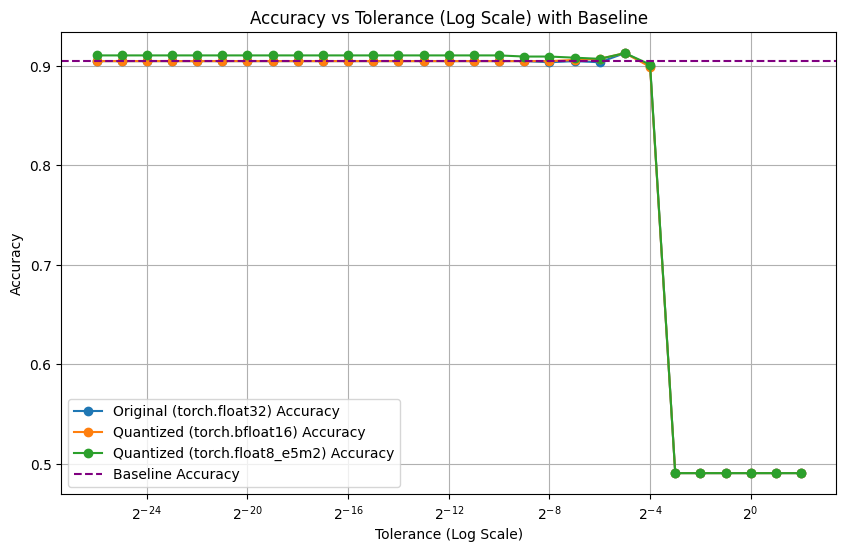

Compression Ratio Original (torch.float32)
Compression Ratio Quantized (torch.bfloat16)
Compression Ratio Quantized (torch.float8_e5m2)


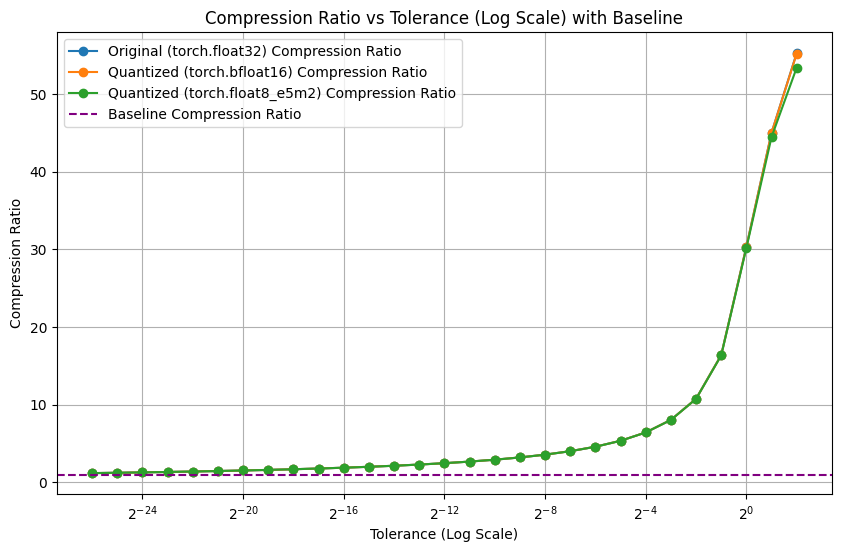

Model Size (MB) Original (torch.float32)
Model Size (MB) Quantized (torch.bfloat16)
Model Size (MB) Quantized (torch.float8_e5m2)


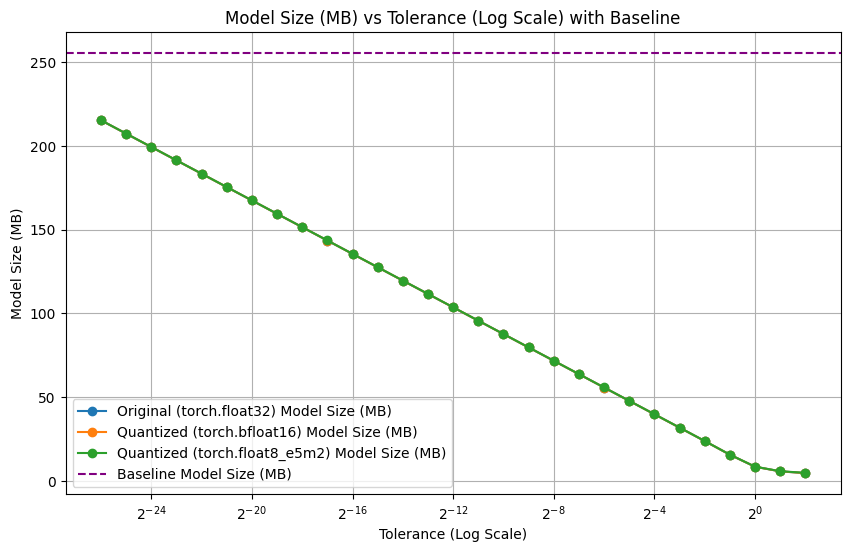

In [16]:
plot_data(log_results, tolerance_values_log, True)

Accuracy Original (torch.float32)
Accuracy Quantized (torch.bfloat16)
Accuracy Quantized (torch.float8_e5m2)


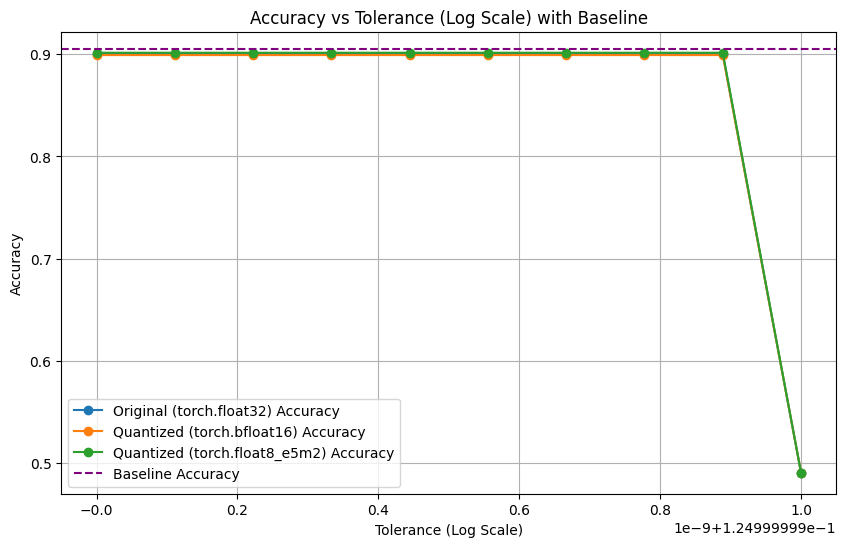

Compression Ratio Original (torch.float32)
Compression Ratio Quantized (torch.bfloat16)
Compression Ratio Quantized (torch.float8_e5m2)


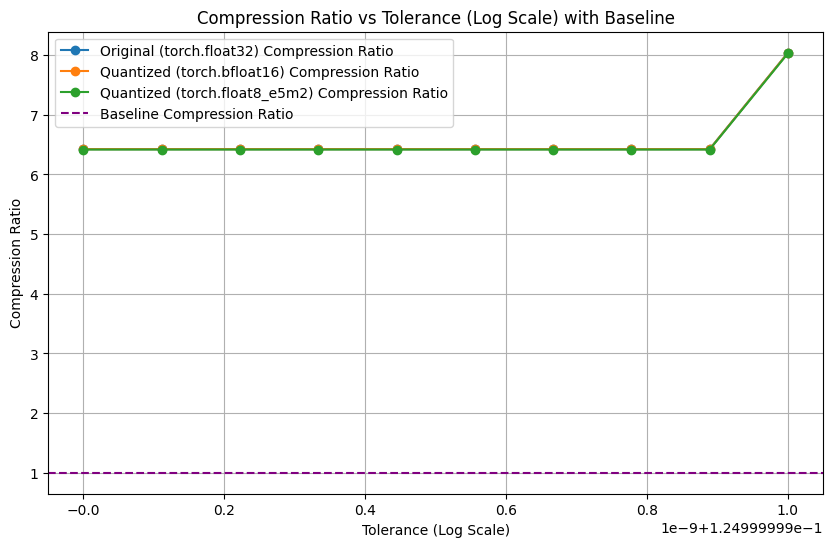

Model Size (MB) Original (torch.float32)
Model Size (MB) Quantized (torch.bfloat16)
Model Size (MB) Quantized (torch.float8_e5m2)


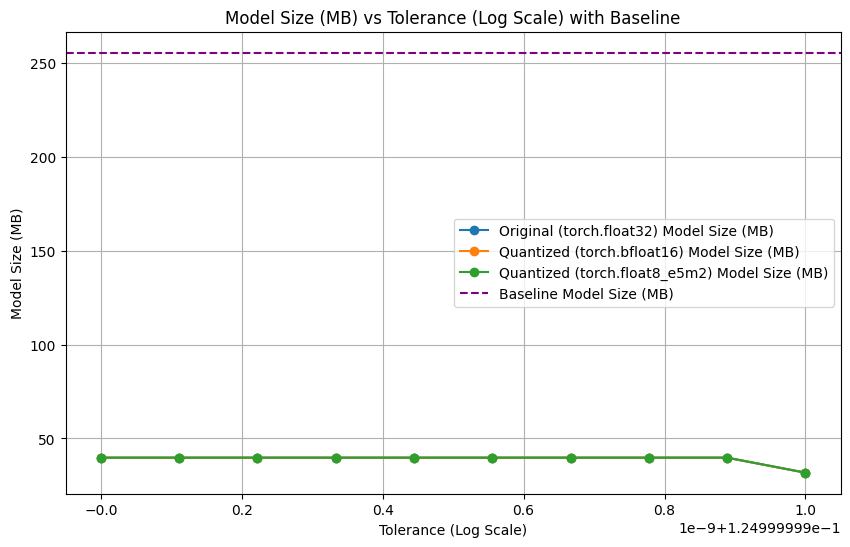

In [17]:
plot_data(even_results, tolerance_values_even, False)

In [18]:
for name, param in org_model.named_parameters():
    copy_param = copy.deepcopy(param)
    param_cpu = copy_param.cpu().detach().numpy()
    print('Before Compression')
    print('Original:', param_cpu[0][0])
    t001 = zfpy.compress_numpy(param_cpu, tolerance=0.001)
    t124 = zfpy.compress_numpy(param_cpu, tolerance=0.124)
    t125 = zfpy.compress_numpy(param_cpu, tolerance=0.125)
    dt001 = zfpy.decompress_numpy(t001)
    dt124 = zfpy.decompress_numpy(t124)
    dt125 = zfpy.decompress_numpy(t125)
    print()

    print('After Decompression')
    print('tolerance=0.001:', dt001[0][0])
    print('tolerance=0.124:', dt124[0][0])
    print('tolerance=0.125:', dt125[0][0])
    break

Before Compression
Original: -0.016623475

After Decompression
tolerance=0.001: -0.016658783
tolerance=0.124: -0.017089844
tolerance=0.125: -0.005859375
